In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
import category_encoders as ce
import impyute
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import time

warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('bmh')

## Exploratory Data Analysis (EDA)

In [2]:
df_orig = pd.read_csv("data/challenge3_train.csv")
df_orig.head(5)
df_orig_with_target = df_orig.copy()

In [3]:
df_orig['target'].value_counts()/len(df_orig)*100

0    56.576
1    43.424
Name: target, dtype: float64

In [4]:
df_orig['f28'].values[:20]

array(['PS', 'DT', 'vq', 'Bx', 'kB', 'mX', 'Mq', 'oJ', 'sc', 'Nh', 'gj',
       'cy', 'vq', 'Dj', 'Sz', 'PS', 'rl', 'rg', 'rM', 'Rv'], dtype=object)

We start by removing the 'id' and the 'target' columns, as the first is simply a unique ID for each row, and the second is the target variable. 

In [5]:
id_ = df_orig[['id']]
target = df_orig[['target']]
df_orig.drop(columns=['id', 'target'], inplace=True)
print(f'Data has {df_orig.shape[0]} rows, each with {df_orig.shape[1]} features.')
df_orig.head(10)
df_orig.head(5)

Data has 50000 rows, each with 31 features.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,13.9681,3.0,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,14.0242,0.0,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,14.2174,0.0,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,13.8536,0.0,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
4,NaN,5.0,0.0,3.0,222.0,NaN,5.0,-8.1088,14.2347,0.0,...,5.0,13.9537,4.0,5.0,NaN,1.0,1.0,kB,5.0,-1.000000


### Missing values
First we check the distribution over missing values for the different features (columns). 

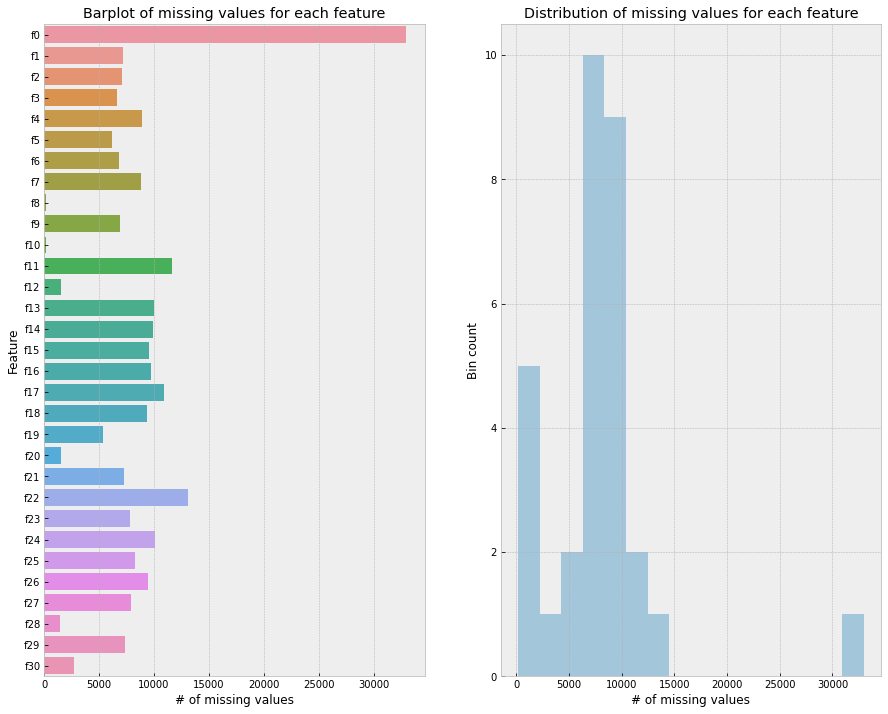

In [6]:
missing_values = df_orig.isna().sum()
fig, ax = plt.subplots(1,2, figsize=(15, 12))
sns.barplot(missing_values.values, missing_values.index, ax=ax[0])
ax[0].set_title("Barplot of missing values for each feature")
ax[0].set_xlabel('# of missing values')
ax[0].set_ylabel('Feature');

sns.distplot(missing_values.values, ax=ax[1], kde=False)
ax[1].set_title("Distribution of missing values for each feature")
ax[1].set_xlabel('# of missing values')
ax[1].set_ylabel('Bin count');


On the left we see a barplot over the number of missing values for each feature. We observe that the feature 'f0' has very many missing values, and that the rest is distributed between 0 to around 13000 missing values. The histogram on the right confirms this. We define a method that will drop all features where the fraction of missing values is above a certain threshold.

In [7]:
def drop_features_with_nan(df, thresh=0.3):
    df2 = df.copy()
    df2 = df2[[column for column in df2 if df2[column].isna().sum() / len(df2) <= thresh]]
    print('Dropped columns: ', end=' ')
    for c in df.columns:
        if c not in df2.columns:
            print(c, end=", ")
    print()
    print(f'# of features after removing those with too many nans: {df2.shape[1]}')
    return df2

In [8]:
df = drop_features_with_nan(df_orig, thresh=0.3)

Dropped columns:  f0, 
# of features after removing those with too many nans: 30


There are still features with many missing values, which needs to be handled. Before we get to that, we explore the different feature types.

### Feature types (continuous vs discrete)
We want to find which features are continuous and which are discrete. This is important because we want to fill in missing values differently depending on the variable is continuous or discrete. As an example, if a feature represented salary, it could make sense to impute missing values using the mean. But for a discrete feature, such as the number of cars a person owns, it does not make sense to impute using mean, as this will most likely result in persons having a 'illegal' (fractional) number of cars (1.3 cars, for instance). 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      42852 non-null  float64
 1   f2      42885 non-null  float64
 2   f3      43352 non-null  float64
 3   f4      41089 non-null  float64
 4   f5      43792 non-null  object 
 5   f6      43176 non-null  float64
 6   f7      41138 non-null  float64
 7   f8      49855 non-null  float64
 8   f9      43135 non-null  float64
 9   f10     49840 non-null  float64
 10  f11     38383 non-null  float64
 11  f12     48487 non-null  object 
 12  f13     40023 non-null  float64
 13  f14     40132 non-null  float64
 14  f15     40430 non-null  object 
 15  f16     40238 non-null  float64
 16  f17     39102 non-null  float64
 17  f18     40592 non-null  float64
 18  f19     44658 non-null  float64
 19  f20     48488 non-null  object 
 20  f21     42717 non-null  float64
 21  f22     36888 non-null  float64
 22

From this we observe that we have mostly numerical values (float64), and some categorical non-numerical values (object). This divides the data into numeric and non-numeric features.

In [10]:
numerical_features = [c for c in df.columns if df[c].dtype == 'float64'] # df.select_dtypes('float64')# 
non_numerical_features = [c for c in df.columns if df[c].dtype == 'object']

In [11]:
print(f'Numerical features:\n{numerical_features} \n')
print(f'Categorical features:\n {non_numerical_features}')


Numerical features:
['f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f13', 'f14', 'f16', 'f17', 'f18', 'f19', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29', 'f30'] 

Categorical features:
 ['f5', 'f12', 'f15', 'f20', 'f28']


#### Non-numerical features
Let's check the distributions for each non-numerical feature. This is useful to know when we later will encode them into numerical values.

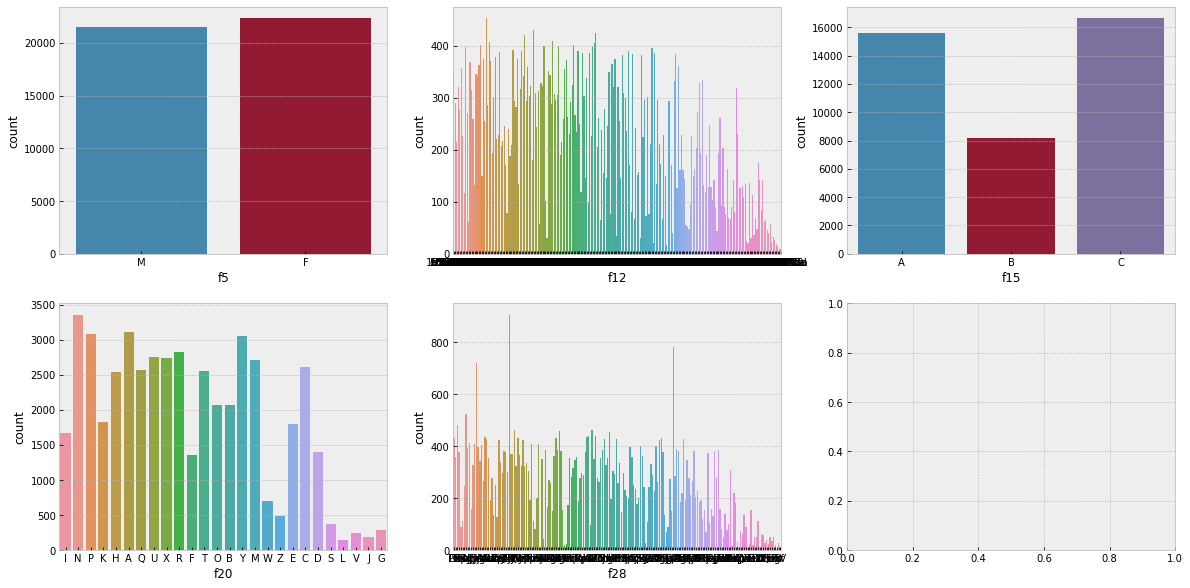

In [12]:
# sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(non_numerical_features, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    #for label in subplot.get_xticklabels():
     #   label.set_rotation(90)

In [13]:
print(f'f12 has {df["f12"].nunique()} unique values')
print(f'f28 has {df["f28"].nunique()} unique values')

f12 has 222 unique values
f28 has 190 unique values


#### Numerical features
Let's check the distributions for each numerical feature.

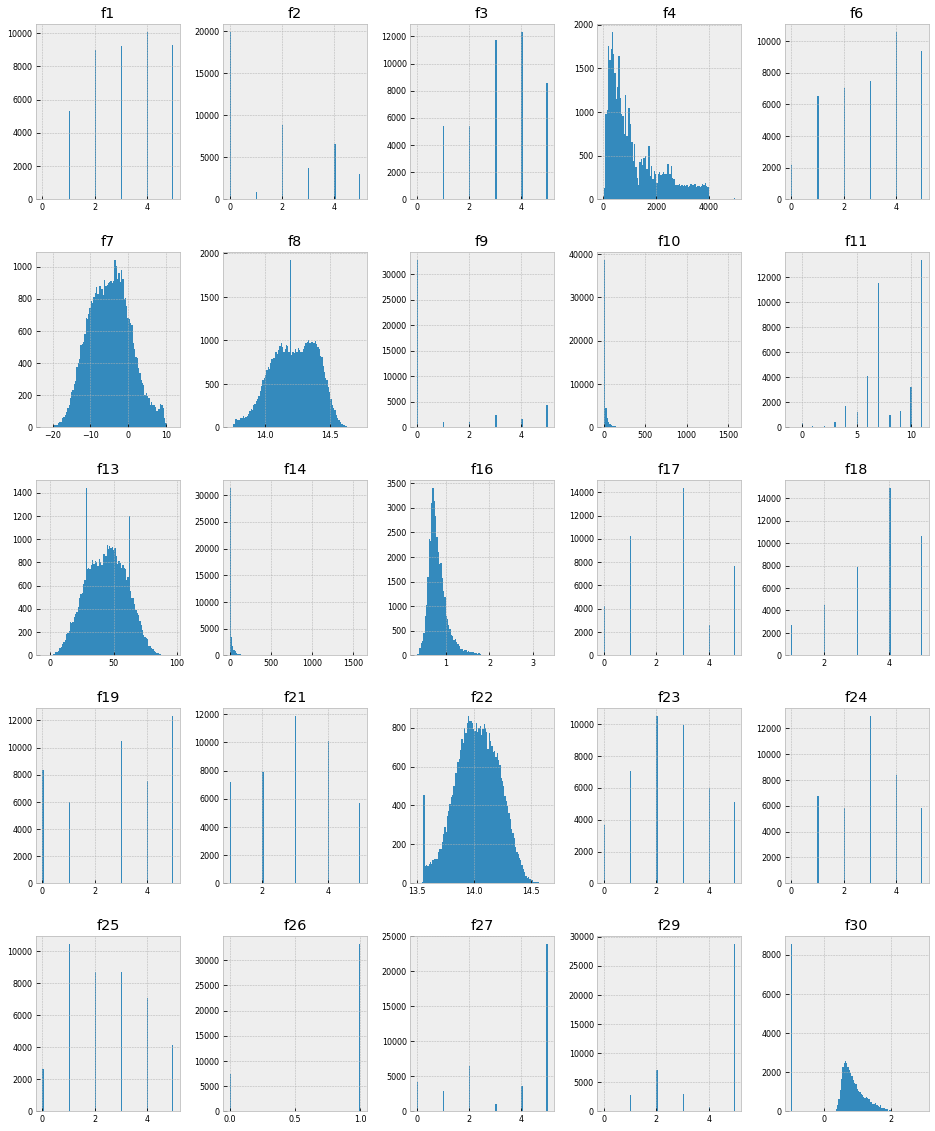

In [14]:
df[numerical_features].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

From above it seems like only 9 of the numerical features are continuous (f4, f7, f8, f10, f13, f14, f16, f22 and f30). The rest can be threated as discrete features. These discrete features may or may not have a natural ordering of their values, that is, they can be ordinal or nominal. Because we do not have feature names available, it is hard to know which are ordinal and which are ordinal.  

We also observe that 'f30' has a lot of '-1' values, a number typically used to denote 'missing value'. Therefore we should converte these to NaNs. 
We also observe that some of the continuous features have very many zero values (f10, f14). It might be the case that the value zero is used to denote 'missing value' for these features (altough this is not so usual). However, we will make a method that will work on a particular column, and replace specific values with the NaN value. 

In [15]:
def replace_with(df, column, value, replace_value=np.nan):
    print(f'[{column}] Replacing {value}s with {replace_value}')
    df2 = df.copy()
    df2[column] = df2[column].apply(lambda v: replace_value if v == value else v)
    return df2

In [16]:
df = replace_with(df, 'f30', -1)
#df = replace_with(df, 'f10', 0)
#df = replace_with(df, 'f14', 0)

[f30] Replacing -1s with nan


### Correlations between numerical values 
It may be useful to look at the correlation between the numerical features. To do so we plot a heatmap and creates some methods for getting the top correlated features. 

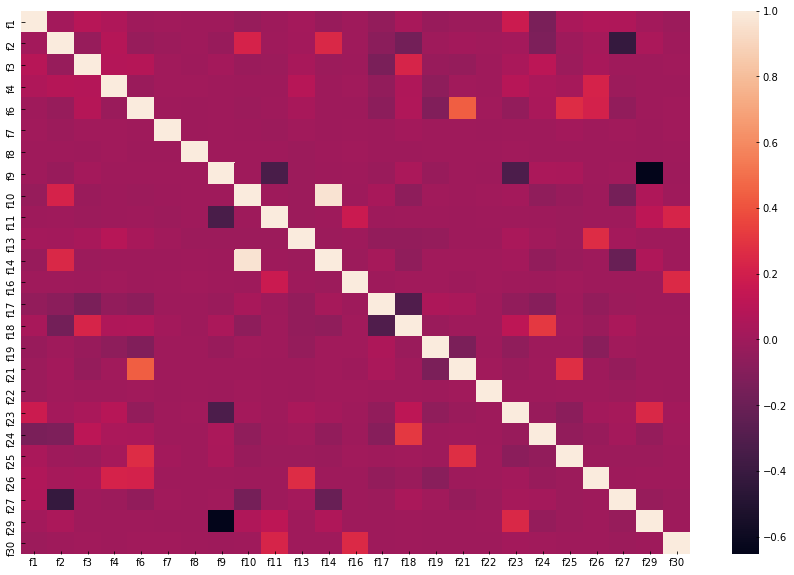

In [17]:
plt.figure(figsize=(15, 10))
num_cols = df.select_dtypes(exclude=['object']).columns
corr = df[num_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

By inspecting the heatmap we observe that most features have a quite low correlation. However, f14 and f10 seems to have a very high correlation. Let's confirm this by looking at the numbers..

In [18]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

num_df = df.select_dtypes('float64')
print("Top Absolute Correlations")
print(get_top_abs_correlations(num_df, 5))

Top Absolute Correlations
f10  f14    0.965998
f9   f29    0.653525
f6   f21    0.443865
f2   f27    0.418460
f9   f11    0.334885
dtype: float64


As we see, f10 and f14 have a correlation of 0.967. We therefore choose to drop one of them. There are two reasons to why we choose to drop highly correlated features:
1. For linear models (e.g. logistic regression), multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.
2. Tree-based models (e.g. decision tree, random forest) can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

More generally, this can be viewed as a special case of Occam's razor. A simpler model is preferable [(1)](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features).

In [19]:
print(f'f10 has {num_df["f10"].isna().sum()} nan values')
print(f'f14 has {num_df["f14"].isna().sum()} nan values')

f10 has 160 nan values
f14 has 9868 nan values


We choose to drop f14 as it has quite many nan values, while f10 has almost no one. But first, because they are so highly correlated, we use f14 to impute nan values for f10.

In [20]:
df.drop(columns=['f14'], inplace=True)
numerical_features.remove('f14')

#### Splitting into discrete and continuous features

Now let's define a method that divides the features into continuous and discrete data. We treat features that have less than a certain threshold number of unique values as discrete, and the rest as continuous. 

In [21]:
def get_discrete_and_continuous_feature(df, threshold=300):
    df2 = df.copy()
    discrete_cols = [c for c in df2.columns if df2[c].nunique() <= threshold]
    cont_cols = [c for c in df2.columns if df2[c].nunique() > threshold]
    return discrete_cols, cont_cols
    

In [22]:
discrete_cols, cont_cols = get_discrete_and_continuous_feature(df)
print(f'Discrete features: {discrete_cols}')
print(f'Continuous features: {cont_cols}')

Discrete features: ['f1', 'f2', 'f3', 'f5', 'f6', 'f9', 'f11', 'f12', 'f13', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29']
Continuous features: ['f4', 'f7', 'f8', 'f10', 'f16', 'f22', 'f30']


### Handle missing values
There are several approaches for handling missing values. In the method chosen for this, we distinguish between continuous and discrete features. 

For continuous features we consider the following methods:
- Mean/Median Imputation
- K-nearest neighbours Imputation
    - Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.
- Iterative Imputation (MICE: Multivariate Imputation by Chained Equations)
    - In Iterative Imputation each variable to be filled with missing values are treated as the dependent variable in a regression, with the other remaining variables as its predictors. It cycles through these models, fitting each in turn, then samples from the gaussian predictive posterior of the fitted estimator for each imputation [(2)](https://www.statsmodels.org/stable/imputation.html) [(3)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).

And for discrete features we consider the following methods:
- Frequent Categorical Imputation
    - Each nan value gets replaced with the most frequent value for that feature.
- Predictive
    - For each feature, a classifier is trained using the other features. This classifier then predicts the nan values for that particular feature.

#### Continuous features
We start by filling in missing values for the continuous features. First we show why it is usual better to apply more sophisticated methods than a simple mean imputation. Let's use 'f22' as an example.

In [ ]:
mean_imputation_df = df.copy()
feat = 'f22'
mean_imputation_df['f22_mean_filled'] = mean_imputation_df[feat].fillna(df[feat].mean())

sns.distplot(mean_imputation_df[feat], hist=False, label=feat)
sns.distplot(mean_imputation_df['f22_mean_filled'], hist=False, label='f22_mean_filled')
plt.legend()
plt.title('Distribution comparison');

We observe that left and right side are reasonably close, but there is a significant difference in distributions is in the center, because mean imputation will just set all missing values to the mean. Now we will use Multivariate Imputation for comparison.

In [ ]:
# imputed = mice(df[cont_cols].values)
start = time.time()
mice_imputation_df = df.copy()
imp = IterativeImputer(max_iter=10, random_state=0, 
                       sample_posterior=True, n_nearest_features=3)
imp.fit(mice_imputation_df[numerical_features])
print(f'Iterative Imputer fitted after {int(time.time()-start)}s')

In [ ]:
start = time.time()
imputed = imp.transform(mice_imputation_df[numerical_features])
print(f'Transformed after {int(time.time()-start)}s')

In [ ]:
idx = mice_imputation_df[numerical_features].columns.tolist().index('f22')
mice_f22 = imputed[:, idx]
sns.distplot(mice_f22, hist=False, label='f22_mice_filled')
sns.distplot(mice_imputation_df[feat], hist=False, label=feat)
plt.legend()
plt.title('Distribution comparison');

We observe that using the Iterative Imputer the distribution of the imputed values is much closer to the original distribution. Let's make a general general method for this. 

In [23]:
def impute_continuous_features(df, feature_df, target_feature_names, method='mice'):
    """
    Args:
        - feature_df: feature_df that the imputer will be fit on 
        - target_feature_names: the features to fill in NaN values for
        - method: the imputation method to use
    """
    start = time.time()
    df2 = df.copy()
    
    if method == 'mice':
        imp = IterativeImputer(max_iter=10, random_state=0, 
                               sample_posterior=True)
        imputed = imp.fit_transform(feature_df)
        
    elif method == 'knn':
        imp = KNNImputer(n_neighbors=2, weights="uniform")
        imputed = imp.fit_transform(feature_df)
        
    elif method == 'mean':
        imp = SimpleImputer(strategy='mean')
        imputed = imp.fit_transform(feature_df)
    
    elif method == 'median':
        imp = SimpleImputer(strategy='median')
        imputed = imp.fit_transform(feature_df)
    
    for feat in target_feature_names:
        idx = feature_df.columns.tolist().index(feat)
        df2[feat] = imputed[:, idx]
        
    print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

Let's compare each imputation method for all the continuous features.

In [24]:
feature_df = df.select_dtypes('float64')
#imp, df_imputed_mean = impute_continuous_features(df, feature_df, cont_cols, method='mean')
#imp, df_imputed_median = impute_continuous_features(df, feature_df, cont_cols, method='median')
imp, df_imputed_knn = impute_continuous_features(df, feature_df, cont_cols, method='knn')
#imp, df_imputed_mice = impute_continuous_features(df, feature_df, cont_cols, method='mice')

Imputation done after 306s


In [25]:
def plot_imputations(df, df_imputed, cont_cols):
    fig, ax = plt.subplots(2, 3, figsize=(20, 7))
    for variable, subplot in zip(cont_cols, ax.flatten()):
        sns.distplot(df[variable], hist=False, label='Without nan', ax=subplot)
        sns.distplot(df_imputed[variable], hist=False, label=f'Filled', ax=subplot)
        subplot.set_yticks([])
        subplot.legend()

#### Mean Imputer

In [ ]:
plot_imputations(df, df_imputed_mean, cont_cols)

#### Median Imputer

In [ ]:
plot_imputations(df, df_imputed_median, cont_cols)

#### KNN Imputer

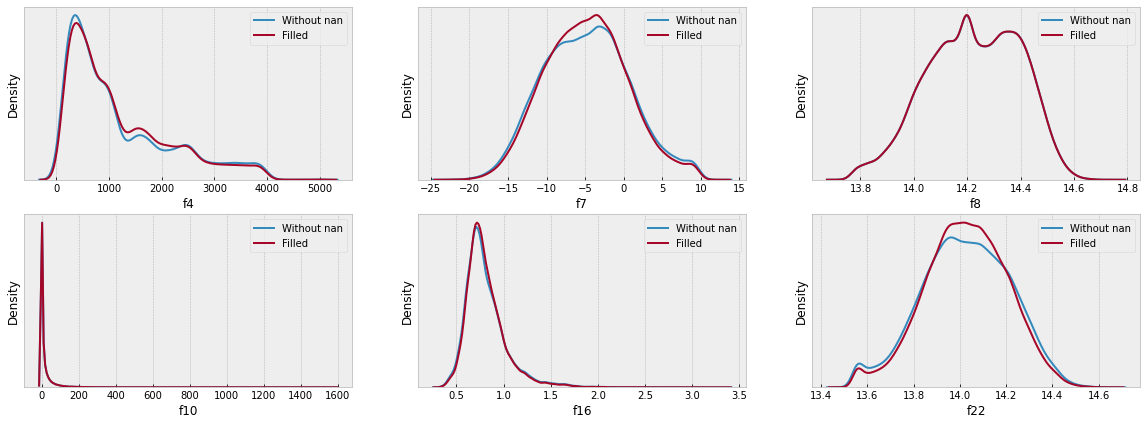

In [26]:
plot_imputations(df, df_imputed_knn, cont_cols)

#### MICE Imputer

In [ ]:
plot_imputations(df, df_imputed_mice, cont_cols)

We observe that the KNN Imputer and the Iterative Imputer (MICE) works best. However, we see that MICE can produce values that are quite far away from any value present in the actual data (due to the estimators being a linear regression model), while using KNN overcomes this issue. Thus, we choose the KNN imputer as our imputer for continuous values.

#### Discrete features
We create a method for imputing discrete features, and then compare the 'most frequent category imputer' to the 'predictive imputer'.

In [27]:
def impute_discrete_features(df, target_feature_names, method='predictive'):
    """
    Args:
        - feature_df: feature_df that the imputer will be fit on 
        - target_feature_names: the features to fill in NaN values for
    """
    start = time.time()
    df2 = df.copy()
    if method == 'most_freq':
        imp = SimpleImputer(strategy='most_frequent')
        imputed = imp.fit_transform(df[target_feature_names])
        for i, c in enumerate(target_feature_names):
            df2[c] = imputed[:, i]
    elif method == 'predictive':
        for feat in target_feature_names:
            clf = DecisionTreeClassifier()
            filtered_df = df[df[feat].notnull()]
            train_x = filtered_df.drop(columns=[feat])
            for c in train_x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(train_x[c].astype(str))
                train_x[c] = encoded_data
            train_x.fillna(0, inplace=True)
            train_y = filtered_df[feat]
            clf.fit(train_x, train_y)
            filtered_df = df[df[feat].isnull()]
            x = filtered_df.drop(columns=[feat])
            for c in x.select_dtypes('object').columns:
                le = LabelEncoder()
                encoded_data = le.fit_transform(x[c].astype(str))
                x[c] = encoded_data
            x.fillna(0, inplace=True)
            x = pd.get_dummies(x)
            y_hat = clf.predict(x)
            nan_idxs = df2[df2[feat].isnull()].index
            df2.loc[nan_idxs, feat] = y_hat
            imp = clf
    print(f'Imputation done after {int(time.time()-start)}s')
    return imp, df2

In [28]:
_, df_imputed_mf = impute_discrete_features(df_imputed_knn, discrete_cols, method='most_freq')
_, df_imputed_pred = impute_discrete_features(df_imputed_knn, discrete_cols)

Imputation done after 1s
Imputation done after 20s


In [29]:
def plot_discrete_imputations(df, df_imputed, disc_cols, n=5):
    disc_cols = disc_cols[:n]
    fig, ax = plt.subplots(n, 2, figsize=(12, 8))
    ax[0][0].set_title('Without nan')
    ax[0][1].set_title('Filled')
    for i, variable in enumerate(disc_cols):
        sns.countplot(df[variable], ax=ax[i][0])
        sns.countplot(df_imputed[variable], ax=ax[i][1])
        #ax[i][0].set_yticks([])
        #ax[i][1].set_yticks([])

Let's compare the distributions (counts) of values, for different features, when using the Frequent Categorical Imputer and the Predictive Imputer.

##### Frequent Categorical Imputer Count Plots

In [ ]:
plot_discrete_imputations(df, df_imputed_mf, discrete_cols, n=3)

##### Predictive Imputer Count Plots

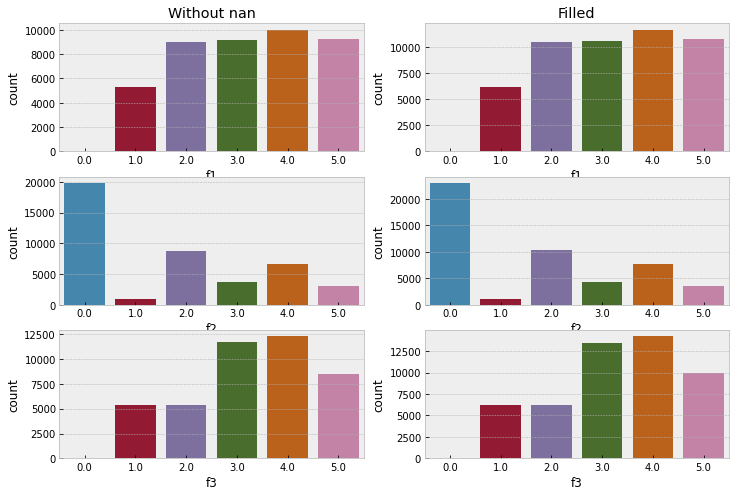

In [30]:
plot_discrete_imputations(df, df_imputed_pred, discrete_cols, n=3)

We observe that for the former, the distributions are not very similar. Due to the nature of the Categorical Frequency Imputer, only the count of the value that originally had the highest frequency has increased, while the rest stays the same. However, for the Predictive Imputer, the distribution stays almost identical, and the counts are spread more evenly among the values. Therefore, we choose this as our imputer for the discrete variables. 

Now, all the nan values should be filled:

In [31]:
df_clean = df_imputed_pred.copy()
print(f'# of nans in data: {sum(df_clean.isna().sum().values)}')

# of nans in data: 0


<AxesSubplot:>

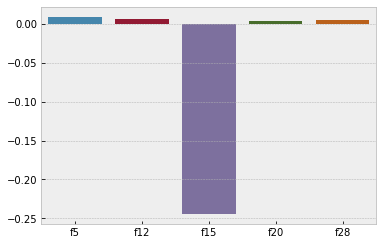

In [32]:
df_objects = df_clean.select_dtypes(include='object')
df_corr = df_objects.copy()

for column in df_corr:
    df_corr[column] = df_corr[column].astype('category').cat.codes
    df_corr[column] = df_corr[column]/df_corr[column].max()

cleaned_corr = df_corr.corrwith(target["target"])
sns.barplot(cleaned_corr.index, cleaned_corr.values)

In [33]:
df_non_objects = df_clean.select_dtypes(exclude='object')
df_corr_2 = df_non_objects.copy()

for column in df_corr_2:
    df_corr_2[column] = df_corr_2[column]/df_corr_2[column].max()

cleaned_corr_2 = df_corr_2.corrwith(target["target"])

<AxesSubplot:>

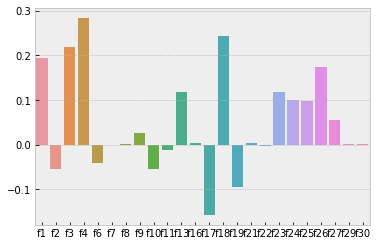

In [34]:
sns.barplot(cleaned_corr_2.index, cleaned_corr_2.values)

In [ ]:
corr_orig = df_orig[df_orig.columns[1:]].corr()['target'][:]
sns.barplot(corr_orig.index, corr_orig.values)

### Feature Encoding

#### Discrete features

From earlier we know the following about our non-numerical features (which are all discrete features):
- f5 takes on two values, which we will binary encode. 
- f15 takes on three values, which we will one-hot encode
- f20 takes on 26 values, for which we will hash-encode.
- f12 and f28 take on 222 and 190 values, respectively. We will also use hash-encoding for these. 

The reason for using hash encoder is because of the many unique values. One does not want to ordinal encode these, as this imposes an ordinal relationship where no such relationship may exist. Furthermore, we do not want to one-hot encode these because of the many columns it will generate, which can lead to the curse of dimensionality. 

The Hash encoder represents categorical features using *n* new dimensions. This way it is a smarter encoder to use when the data has high cardinality (as f20, f12 and f28 has). 

For rest of the discrete features we use one-hot-encoding, as these have a limited amount of unique values. 

In [44]:
def hash_encode(df, column, n_components=10):
    df2 = df.copy()
    encoder = ce.HashingEncoder(cols=column, n_components=n_components)
    df2 = encoder.fit_transform(df2)
    df2.rename(columns={f'col_{i}': f'{column}_{i}' for i in range(n_components)}, inplace=True)
    return encoder, df2                       

In [45]:
encoder, df2 = hash_encode(df_clean, 'f20')

In [ ]:
df2 = df2.drop(columns=['f12', 'f28'])

In [48]:
df3 = df2.copy()
dummies = pd.get_dummies(df3[['f15']])
df3 = pd.concat([df3, dummies], axis=1)
#df3 = df3.reindex(sorted(df.columns), axis=1)
df3 = df3.drop(columns=['f15'], axis=1)

In [53]:
df4 = df3.copy()
df4['f5'].replace(['M', 'F'],  [0, 1], inplace=True)

In [54]:
y_train = np.asarray(target.target)
X_train = df4

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f}'.format(rf.score(X_train, y_train), rf.oob_score_))

R^2 Training Score: 0.92 
OOB Score: 0.45


In [65]:
col_sorted_by_importance=rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':X_train.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})

import plotly_express as px
px.bar(feat_imp, x='cols', y='imps')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'cols=%{x}<br>imps=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa'},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['f20_7', 'f15_B', 'f20_0', 'f20_9', 'f20_8', 'f20_1', 'f20_6', 'f20_4',
                          'f20_3', 'f20_2', 'f20_5', 'f5', 'f9', 'f29', 'f15_C', 'f27', 'f2',
                          'f17', 'f19', 'f11', 'f23', 'f24', 'f10', 'f15_A', 'f26', 'f21', 'f1',
                          'f22', 'f30', 'f16', 'f3', 'f8', 'f7', 'f25', 'f13', 'f6', 'f18', 'f4'],
                         dtype=object),
              'xaxis': 'x',
              'y': array([0.00108978, 0.00203377, 0.00211624, 0.00321061, 0.00341316, 0.00342436,
                          0.00345119, 0.00378314, 0.00401109, 0.00405559, 0.00482663, 0.00560227,
                          0.00678781, 0.00829231, 0.00901034, 0.01013586, 0.01139223, 0.01381592,
                          0.01424229, 0.0149169 , 0.01738187, 0.01767095, 0.0276486 , 0.03169271,
                          0.03248879, 0.03305225, 0.03497238, 0.04534471, 0.04540917, 0.04553904,
                          0.04586722, 0.04617141, 0.04665639, 0.05028254, 0.05562655, 0.06643607,
                          0.0974136 , 0.13073427]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'cols'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'imps'}}}
})